13 December 2023

**Author:** Sam Muir

**Link to repository:** https://github.com/shmuir/phoenix-biodiversity-index

# Biodiversity Intactness Index (BII) in Phoenix, AZ: <br> Changes from 2017 to 2020

## Purpose

Land development is a prominent factor in the loss of terrestrial biodiversity. Urbanization of natural area puts stress on species and threatens ecosystem resilliance. In this notebook I will be exploring the change in the Biodiversity Intactnes Index (BII) for Phoeniz, Arizona. Specifically, I will be analyzing the differences between 2017 and 2020. BII estimates how the abundance of native terrestrial species in a region compares with their abundances before significant human impacts. Phoenix in particular has seen a lot of urbanization in recent years so it will be interesting to investgate and visualize the BII changes between these two years.

## Highlights of Analysis

- Fetching raster data
- Loading and visualizing the study are is geographical context
- Clipping rater data to study region area
- Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 for both years
- Visualization the area with BII ≥ 0.75 in 2017 that was lost by 2020
 
## Data
#### Data Description

The BII dataset is part of the Microsoft Planetary Computer (MPC) SpatioTemporal Asset Catalog (STAC), stored as `io-biodiversity`. This is raster data for terrestrial biodiversity intactness at 100m resolution. The shapefile for the Phoenix subdivision comes from the Census County Subdivision shapefiles for Arizona.  

#### Data References

[Microsoft Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog)

[U.S. Census TIGER Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions)


## Importing Data

In [1]:
# load necessary libraries
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Polygon
# for creating legends
import matplotlib.patches as mpatches 

# used to access STAC catalogs
from pystac_client import Client
#used to sign items from the MPC STAC catalog
import planetary_computer
# other libraries for nice outputs
from IPython.display import Image
# for geographical context map
import contextily as cx

In [2]:
# read in census shapefile
phoenix_census = gpd.read_file('tl_2022_04_cousub/tl_2022_04_cousub.shp')

# access mpc catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# get bii from catalog
bii_collection = catalog.get_child('io-biodiversity')

# phoenix bounding box
bbox = {
    "type": "Polygon",
    "coordinates":[
        [[-111.17544349576511, 33.867435662315955],
            [-112.82552110133373, 33.867435662315955],
            [-112.82552110133373, 32.97048235813784],
            [-111.17544349576511, 32.97048235813784],
            [-111.17544349576511, 33.867435662315955]]],}

# catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    intersects=bbox)
# get items
items = search.item_collection()

# get bii for the two years
bii2017 = items[3] # 2017
bii2020 = items[0] # 2020

# access the bii data
phoenix2017 = rioxr.open_rasterio(bii2017.assets['data'].href)
phoenix2020 = rioxr.open_rasterio(bii2020.assets['data'].href)

# select Phoenix from census data
phoenix_geom = phoenix_census[phoenix_census.NAME == 'Phoenix']
# make sure bii and census have the same crs
phoenix_geom = phoenix_geom.to_crs(phoenix2017.rio.crs)

## Data Exploration

In [3]:
print(type(phoenix2017))
print(type(phoenix_geom))

<class 'xarray.core.dataarray.DataArray'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [4]:
print(phoenix2017)
print(phoenix2020)

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


<Axes: >

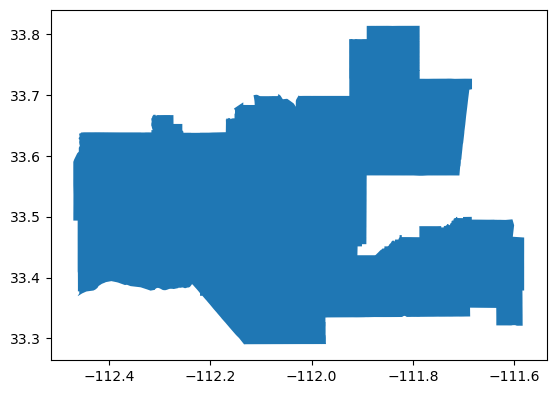

In [5]:
phoenix_geom.plot()

## Geographical Context of Data

As mentioned, I am interested in the Phoenix subdivision, which we can see from the data exploration above, but let's see what this area looks like in geographical context. To do this, I am using the `contextily` library. 

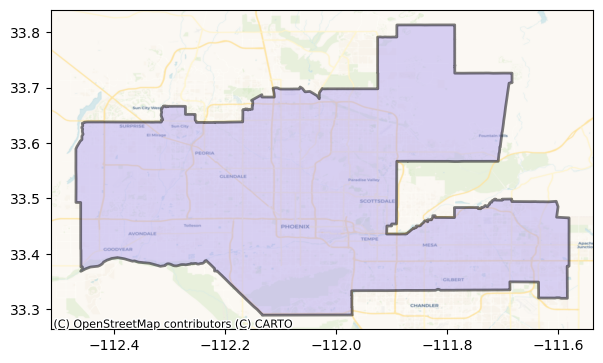

In [6]:
ax = phoenix_geom.plot(facecolor="#b5a8f0",
                   edgecolor="black",
                   linewidth=2,
                      alpha = 0.5,
                      figsize=(7, 7))
cx.add_basemap(ax,
               crs=phoenix_census.crs.to_string(),
               source=cx.providers.CartoDB.Voyager)

## Analysis

Before beginning the analysis, we need to clip the raster to the extent of the Phoenix census data. 

In [7]:
phoenix2017_clip = phoenix2017.rio.clip(phoenix_geom['geometry'])
phoenix2020_clip = phoenix2020.rio.clip(phoenix_geom['geometry'])

### Calculating percentage area with a BII ≥ 0.75 

Now that we have our clipped rater, we want to find the percent of area that has a BII greater than or equal to 0.75. Filtering will give us an array of True/False, so we will also convert those value to 0/1. By dividing the filtered BII area by the total area and multiplying by 100, we will get the percent area. 

In [8]:
phoenix2017_filter = (phoenix2017_clip >= 0.75).astype('int')
phoenix2020_filter = (phoenix2020_clip >= 0.75).astype('int')

In [9]:
print("In 2017,",round((phoenix2017_filter.values.sum() / (phoenix2017_clip.rio.width * phoenix2017_clip.rio.height)) * 100, 3),"percent of Phoenix had a BII of ≥ 0.75.")

In 2017, 4.181 percent of Phoenix had a BII of ≥ 0.75.


In [10]:
print("In 2020,", round((phoenix2020_filter.values.sum() / (phoenix2020_clip.rio.width * phoenix2020_clip.rio.height)) * 100, 3), "percent of Phoenix had a BII of ≥ 0.75.")

In 2020, 3.809 percent of Phoenix had a BII of ≥ 0.75.


### Mapping the lost area

From the percentages calculated above we can see that there was some area with a BII of ≥0.75 in 2017 that was lost in 2020. To visualize this loss, lets plot the lost area ontop of the BII for 2020. 

To do this, we'll need to find the difference between the 2017 and 2020 BII values, and convert area that were not lost to `nan`. 

In [11]:
difference = phoenix2017_filter - phoenix2020_filter # find diff
diff = difference.where(difference == 1) # keep only values of 1 and rest will be nan

Now we're ready to plot the results!

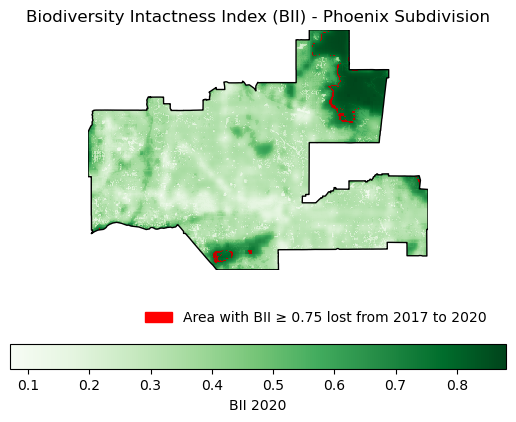

In [12]:
fig, ax = plt.subplots() # initialize plot

ax.axis("off") # remove axis

# plot 2020 BII
bii = phoenix2017_clip.plot(ax=ax,
                            cmap='Greens', # update color map
                            add_colorbar = False) # remove colorbar here, but will add in fig.colorbar
# plot lost area
diff.plot(ax=ax, 
          cmap = 'gist_heat', # update color map to be visible ontop of BII
          add_colorbar=False)
red_patch = mpatches.Patch(color='red', # patch for lost area
                           label='Area with BII ≥ 0.75 lost from 2017 to 2020')

# outline of phoenix area
phoenix_geom.plot(ax=ax,
                  facecolor="none",
                   edgecolor="black",
                   linewidth=1)

# legend for lost area
ax.legend(handles=[red_patch], frameon=False, loc = (0.15, -0.25))

ax.set_title("Biodiversity Intactness Index (BII) - Phoenix Subdivision")

# add color bar and move to bottom of the plot
fig.colorbar(bii, orientation="horizontal", pad=0.2, label = "BII 2020")

plt.show()

Based on the map, it might be interesting to look at the BII in surrounding cities as well. We can see areas with high BII near the edges of the city so expanding the analysis further might also reveal more high BII areas that were lost from 2017 to 2020. 